# Using ModelHandler with Gluon

MXNet's Gluon framework allows Neural Networks to be written under an imperative paradigm.  ModelHandler is currently based around the symbolic graph implementation of MXNet and as a result, models written in Gluon cannot directly be used.

If the model is written in Gluon using [HybridBlocks](https://gluon.mxnet.io/chapter07_distributed-learning/hybridize.html) (i.e. if the network consists entirely of predefined MXNet layers) then the model can be compliled as a symbolic graph using the command `.hybridize()`.

The Gluon defined model can then be converted to a symbol and set of parameters which can then be loaded as an MXNet Module and used with ModelHandler.

In this demo, we will show that you can define a model in Gluon using code from the [Gluon MNIST demo](https://mxnet.incubator.apache.org/tutorials/gluon/mnist.html) and then convert it to a Module and use ModelHandler.

In [1]:
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd as ag

import os

# Fixing the random seed
mx.random.seed(42)

## Train model in Gluon

### Define model in Gluon

In [2]:
mnist = mx.test_utils.get_mnist()

In [3]:
batch_size = 100
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

In [4]:
# define network
net = nn.HybridSequential()
with net.name_scope():
    net.add(nn.Dense(128, activation='relu'))
    net.add(nn.Dense(64, activation='relu'))
    net.add(nn.Dense(10))
    
net.hybridize()

In [5]:
gpus = mx.test_utils.list_gpus()
ctx =  [mx.gpu()] if gpus else [mx.cpu(0), mx.cpu(1)]
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02})

### Training

In [6]:
%%time
epoch = 10
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
for i in range(epoch):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    for batch in train_data:
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes softmax cross entropy loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropagate the error for one iteration.
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        # Make one step of parameter update. Trainer needs to know the
        # batch size of data to normalize the gradient by 1/batch_size.
        trainer.step(batch.data[0].shape[0])
    # Gets the evaluation result.
    name, acc = metric.get()
    # Reset evaluation result to initial state.
    metric.reset()
    print('training acc at epoch {}: {}={}'.format(i, name, acc))

training acc at epoch 0: accuracy=0.7816
training acc at epoch 1: accuracy=0.89915
training acc at epoch 2: accuracy=0.9134666666666666
training acc at epoch 3: accuracy=0.9225833333333333
training acc at epoch 4: accuracy=0.9305666666666667
training acc at epoch 5: accuracy=0.9366666666666666
training acc at epoch 6: accuracy=0.9418166666666666
training acc at epoch 7: accuracy=0.94585
training acc at epoch 8: accuracy=0.9495333333333333
training acc at epoch 9: accuracy=0.9532333333333334
CPU times: user 43.1 s, sys: 4.18 s, total: 47.3 s
Wall time: 29.7 s


## Testing

In [7]:
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
# Reset the validation data iterator.
val_data.reset()
# Loop over the validation data iterator.
for batch in val_data:
    # Splits validation data into multiple slices along batch_axis
    # and copy each slice into a context.
    data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
    # Splits validation label into multiple slices along batch_axis
    # and copy each slice into a context.
    label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
    outputs = []
    for x in data:
        outputs.append(net(x))
    # Updates internal evaluation
    metric.update(label, outputs)
print('validation acc: {}={}'.format(*metric.get()))
assert metric.get()[1] > 0.94

validation acc: accuracy=0.9527


## Convert Gluon model to Module

*Adapted from snippet found [here](https://github.com/apache/incubator-mxnet/issues/9374)*

From the Gluon model, the symbol and parameters are extracted and used to define an `Module` object.

In [8]:
def block2symbol(block):
    data = mx.sym.Variable('data')
    sym = block(data)
    args = {}
    auxs = {}
    for k, v in block.collect_params().items():
        args[k] = mx.nd.array(v.data().asnumpy())
        auxs[k] = mx.nd.array(v.data().asnumpy())
    return sym, args, auxs

In [9]:
def symbol2mod(sym, args, auxs, data_iter):
    mx_sym = mx.sym.SoftmaxOutput(data=sym, name='softmax')
    model = mx.mod.Module(symbol=mx_sym, context=mx.cpu(), 
                          label_names=['softmax_label'])
    model.bind( data_shapes = data_iter.provide_data, 
                label_shapes = data_iter.provide_label )
    model.set_params(args, auxs)  
    return model

In [10]:
sym_params = block2symbol(net)

In [11]:
mod = symbol2mod(*sym_params, train_data)

### Alternative Method

Serialise Gluon model to file using `.export()`.

Load the serialised model as an MXNet Module with `Module.load()` so that xfer can be used.

In [12]:
# model_name = 'gluon-model'
# net.export(model_name)

# mod = mx.mod.Module.load(model_name, 0, label_names=[])
# os.remove(model_name+'-symbol.json')
# os.remove(model_name+'-0000.params')

## Apply ModelHandler

Now we can load the model into ModelHandler and use it to visualise the model, return the layer names, extract features and much more!

In [13]:
import xfer

In [14]:
mh = xfer.model_handler.ModelHandler(mod)

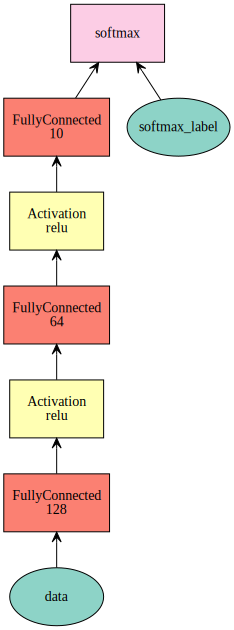

In [15]:
# Show architecture of model
mh.visualize_net()

In [16]:
mh.layer_names

['hybridsequential0_dense0_fwd',
 'hybridsequential0_dense0_relu_fwd',
 'hybridsequential0_dense1_fwd',
 'hybridsequential0_dense1_relu_fwd',
 'hybridsequential0_dense2_fwd',
 'softmax']

In [17]:
# Get output from intermediate layers of the model
mh.get_layer_output(train_data, ['hybridsequential0_dense1_fwd'])

(OrderedDict([('hybridsequential0_dense1_fwd',
               array([[ 1.93497527e+00,  2.40295935e+00,  1.16074115e-01, ...,
                       -4.74348217e-02, -3.76087427e-03,  1.39985621e+00],
                      [ 2.15391922e+00,  1.97971451e+00,  4.61517543e-01, ...,
                        2.28680030e-01, -8.29489648e-01,  9.69915807e-01],
                      [ 2.06626105e+00,  4.06703472e+00,  7.65578270e-01, ...,
                        3.74726385e-01,  1.03201318e+00, -5.41208267e-01],
                      ...,
                      [ 2.55671740e+00,  4.17255354e+00,  5.60081601e-01, ...,
                        5.68660349e-02, -1.58825326e+00,  1.59997427e+00],
                      [ 2.30686831e+00,  2.34434009e+00, -5.84015131e-01, ...,
                        3.16424906e-01, -1.08476102e-01,  6.86561584e-01],
                      [ 9.71719801e-01,  1.08340001e+00,  1.72682357e+00, ...,
                       -2.98302293e-01,  1.48507738e+00, -7.40276098e-01]], d

In [18]:
mh.get_layer_type('hybridsequential0_dense0_relu_fwd')

'Activation'

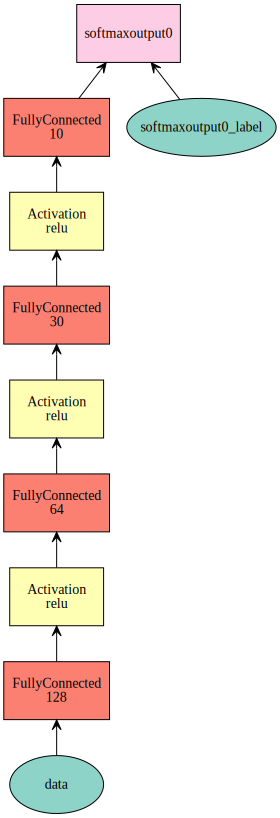

In [19]:
# Add/Remove layers from model output
mh.drop_layer_top(2)
mh.add_layer_top([mx.sym.FullyConnected(num_hidden=30),
                  mx.sym.Activation(act_type='relu'),
                  mx.sym.FullyConnected(num_hidden=10),
                  mx.sym.SoftmaxOutput()])
mh.visualize_net()

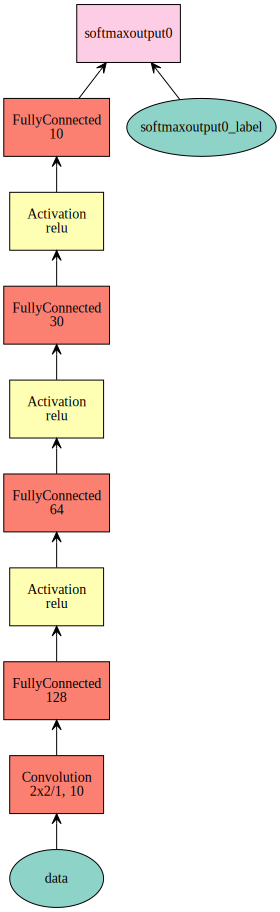

In [20]:
# Add/remove layers from model input
mh.add_layer_bottom([mx.sym.Convolution(kernel=(2,2), num_filter=10)])
mh.visualize_net()